In [1]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

import torch.nn.functional as F
import torchaudio.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from IPython.display import Audio, display
from data.datasets import ArcticDataset, TIMITDataset
from tqdm.notebook import tqdm

1.11.0+cu113
0.11.0+cu113


/home/maxim/VisibleSpeech/PhonemeRecognizer/venv/lib/python3.10/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


# CUDA

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Dataset

In [3]:
vowel_labels = ['IY', 'IH', 'EH', 'EY', 'AE', 'AA', 'AW', 'AY', 'AH', 'AO', 'OY', 'OW', 'UH', 'UW', 'UX', 'ER', 'AX',
                'IX', 'AXR', 'AH-H']

In [4]:
consonant_labels = ['B', 'D', 'G', 'P', 'T', 'K', 'DX', 'Q',
                    'JH', 'CH', 'S', 'SH', 'Z', 'ZH', 'F', 'TH', 'V', 'M', 'N', 'NG', 'EM', 'EN', 'ENG', 'NX']

In [5]:
phone_labels = vowel_labels + consonant_labels
phone_labels

['IY',
 'IH',
 'EH',
 'EY',
 'AE',
 'AA',
 'AW',
 'AY',
 'AH',
 'AO',
 'OY',
 'OW',
 'UH',
 'UW',
 'UX',
 'ER',
 'AX',
 'IX',
 'AXR',
 'AH-H',
 'B',
 'D',
 'G',
 'P',
 'T',
 'K',
 'DX',
 'Q',
 'JH',
 'CH',
 'S',
 'SH',
 'Z',
 'ZH',
 'F',
 'TH',
 'V',
 'M',
 'N',
 'NG',
 'EM',
 'EN',
 'ENG',
 'NX']

In [6]:
timit_dataset_train = TIMITDataset(usage='train', root_dir='/media/maxim/Programming/voice_datasets/timit/TIMIT_2/data',
                                   phone_codes=phone_labels, padding=16000, description_file_path='../../data/timit_description.csv')

timit_dataset_test = TIMITDataset(usage='test',  root_dir='/media/maxim/Programming/voice_datasets/timit/TIMIT_2/data',
                                  phone_codes=phone_labels, padding=16000, description_file_path='../../data/timit_description.csv')

print(f'Length of the train dataset: {len(timit_dataset_train)}')
print(f'Length of the test dataset: {len(timit_dataset_test)}')
print(timit_dataset_train[0])

timit_waveform = timit_dataset_train[0].data
timit_framerate = timit_dataset_train[0].frame_rate
print(timit_waveform.shape)

Length of the train dataset: 117745
Length of the test dataset: 42375
AudioData(data=tensor([[0.0079, 0.0092, 0.0094,  ..., 0.0000, 0.0000, 0.0000]]), label='IH', frame_rate=16000, sample_width=16)
torch.Size([1, 16000])


In [7]:
labels = sorted(list(set(datapoint.label for datapoint in timit_dataset_train)))

In [8]:
len(labels)

43

# Transforms

M


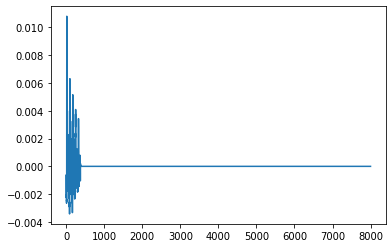

In [9]:
transform = T.Resample(orig_freq=timit_framerate, new_freq=8000)

item = 50
timit_waveform = timit_dataset_train[item].data
print(timit_dataset_train[item].label)

transformed = transform(timit_waveform)
display(Audio(transformed.numpy(), rate=8000))
plt.plot(transformed.t().numpy());

# Formatting

In [10]:
def label_to_index(phone):
    return torch.tensor(labels.index(phone))


def index_to_label(index):
    return labels[index]


In [11]:
phone_start = "EY"
index = label_to_index(phone_start)
word_recovered = index_to_label(index)

print(phone_start, "-->", index, "-->", word_recovered)

EY --> tensor(17) --> EY


In [12]:
def pad_sequence(batch):
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):
    tensors, targets = [], []

    for waveform, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


In [13]:

batch_size = 16

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    timit_dataset_train,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    timit_dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
print(transformed.shape[0])

Feature batch shape: torch.Size([16, 1, 16000])
Labels batch shape: torch.Size([16])
1


In [14]:
type(next(iter(train_loader)))

tuple

# Models

## M11

In [15]:
from models.m_models import M11

model = M11(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

M11(
  (conv1): Conv1d(1, 64, kernel_size=(80,), stride=(4,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv_layers_2): MBlock(
    (layers): Sequential(
      (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv_layers_3): MBlock(
    (layers): Sequential(
      (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  

In [16]:
train_features, train_labels = next(iter(train_loader))
output = model(transform(train_features).to(device))
output.squeeze().shape, train_labels.shape

(torch.Size([16, 43]), torch.Size([16]))

In [17]:
import torchmetrics

acc = torchmetrics.functional.accuracy(output.squeeze(), train_labels.to(device))
prec_rec = torchmetrics.functional.precision_recall(output.squeeze(), train_labels.to(device), num_classes=len(labels))
acc, prec_rec

(tensor(0., device='cuda:0'),
 (tensor(0., device='cuda:0'), tensor(0., device='cuda:0')))

In [18]:
next(train_loader)

TypeError: 'DataLoader' object is not an iterator

## Train and test

In [19]:
log_interval = 100
n_epoch = 40

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

In [20]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)

        target = target.to(device)

        data = transform(data)
        output = model(data)

        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.update(pbar_update)

        if batch_idx % log_interval == 0:
            print(
                f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        losses.append(loss.item())

In [21]:
def number_of_correct(pred, target):
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    return tensor.argmax(dim=-1)


def test(model, epoch, loader):
    model.eval()
    correct = 0
    for data, target in loader:
        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

    print(correct, len(loader.dataset), (correct / len(loader.dataset)) * 100.0)

    return (correct / len(loader.dataset)) * 100.0


### TIMIT Corpus

In [22]:
import matplotlib.pyplot as plt

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        print(f'On train: {test(model, epoch, train_loader):.0f}%')
        print(f'On test: {test(model, epoch, test_loader):.0f}%')
        scheduler.step()

# Let's plot the training loss versus the number of iteration.
plt.plot(losses)
plt.title("training loss")

  0%|          | 0/40 [00:00<?, ?it/s]

Train Epoch: 1 [0/117745 (0%)]	Loss: 3.752015
Train Epoch: 1 [1600/117745 (1%)]	Loss: 3.396813
Train Epoch: 1 [3200/117745 (3%)]	Loss: 2.873879
Train Epoch: 1 [4800/117745 (4%)]	Loss: 3.094960
Train Epoch: 1 [6400/117745 (5%)]	Loss: 2.663580
Train Epoch: 1 [8000/117745 (7%)]	Loss: 3.004570
Train Epoch: 1 [9600/117745 (8%)]	Loss: 2.896598
Train Epoch: 1 [11200/117745 (10%)]	Loss: 3.003952
Train Epoch: 1 [12800/117745 (11%)]	Loss: 3.253292
Train Epoch: 1 [14400/117745 (12%)]	Loss: 2.446271
Train Epoch: 1 [16000/117745 (14%)]	Loss: 2.438562
Train Epoch: 1 [17600/117745 (15%)]	Loss: 2.651240
Train Epoch: 1 [19200/117745 (16%)]	Loss: 2.748521
Train Epoch: 1 [20800/117745 (18%)]	Loss: 2.420638
Train Epoch: 1 [22400/117745 (19%)]	Loss: 2.321151
Train Epoch: 1 [24000/117745 (20%)]	Loss: 2.291561
Train Epoch: 1 [25600/117745 (22%)]	Loss: 2.566095
Train Epoch: 1 [27200/117745 (23%)]	Loss: 2.256928
Train Epoch: 1 [28800/117745 (24%)]	Loss: 2.507891
Train Epoch: 1 [30400/117745 (26%)]	Loss: 2.0802

KeyboardInterrupt: 

In [ ]:
def predict(tensor):
    tensor = tensor.to(device)
    tensor = transform(tensor)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor


data, label, frame_rate, sample_width = timit_dataset_train[7]

print(f"Expected: {label}. Predicted: {predict(data)}.")